In [ ]:
!pip install ultralytics
!pip install supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.3/872.3 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 5.5 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO
import supervision as sv
import torch
import cv2
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.widgets import Cursor


In [ ]:
# prompt: mount github
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# access video
video_dataset = '/content/drive/MyDrive/sunway/q1/traffic_dataset/british_highway_traffic.mp4'
cap = cv2.VideoCapture(video_dataset)
ret, frame=cap.read()

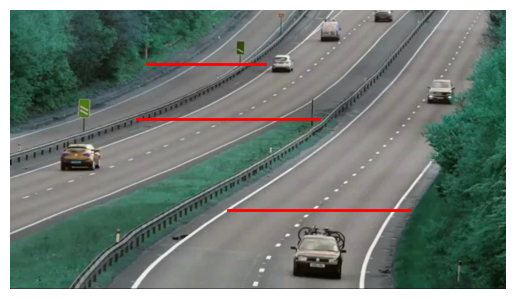

In [ ]:

# Convert BGR to RGB for matplotlib
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Define line coordinates (start and end points)
p1_s = (600, 550)  # Example coordinates
p1_e = (1100,550)   # Example coordinates
p2_s = (850, 300)
p2_e = (350,300)
p3_s = (700, 150)
p3_e = (375,150)

# Plotting the line
plt.imshow(frame)
plt.plot([p1_s[0], p1_e[0]], [p1_s[1], p1_e[1]], color='red', linewidth=2)
plt.plot([p2_s[0], p2_e[0]], [p2_s[1], p2_e[1]], color='red', linewidth=2)
plt.plot([p3_s[0], p3_e[0]], [p3_s[1], p3_e[1]], color='red', linewidth=2)

plt.axis('off')  # Hide axes
plt.show()

In [ ]:
# use YOLOv10
model = YOLO('yolov10n.pt')

# coordinate
point1 = sv.Point(600, 550)
point2 = sv.Point(1100, 550)

point3 = sv.Point(750, 300)
point4 = sv.Point(425, 300)

point5 = sv.Point(575, 150)
point6 = sv.Point(425, 150)

In [ ]:
tracked = defaultdict(lambda: [])
crossed_objects_lane1 = {}
crossed_objects_lane2 = {}
crossed_objects_lane3 = {}
video_info = sv.VideoInfo.from_video_path(video_dataset)
with sv.VideoSink("output.mp4", video_info) as sink:
  while cap.isOpened():
    success, frame=cap.read()
    if success:
      # 2: car; 3: motorcycle; 5: bus; 7: truck
      results = model.track(frame, classes=[2, 3, 5, 7], persist=True, save=True, tracker='bytetrack.yaml')
      boxes = results[0].boxes.xywh.cpu()
      track_ids = results[0].boxes.id.int().cpu().tolist()
      annotated_frame = results[0].plot()
      detections = sv.Detections.from_ultralytics(results[0])
      for box, track_id in zip(boxes, track_ids):
        x, y, w, h = box
        track = tracked[track_id]
        track.append((float(x), float(y)))
        if len(track) > 30:
          track.pop(0)

        if point1.x < x < point2.x and abs(y-point1.y) < 5:
          if track_id not in crossed_objects_lane1:
            crossed_objects_lane1[track_id]=True
          cv2.rectangle(annotated_frame, (int(x-w/2), int(y-h/2)), (int(x+w/2),int(y+h/2)), (0, 255, 0), 2)
        elif point4.x < x < point3.x and abs(y-point4.y) < 5:
          if track_id not in crossed_objects_lane2:
            crossed_objects_lane2[track_id]=True
          cv2.rectangle(annotated_frame, (int(x-w/2), int(y-h/2)), (int(x+w/2),int(y+h/2)), (0, 255, 0), 2)
        elif point6.x < x < point5.x and abs(y-point6.y) < 10:
          if track_id not in crossed_objects_lane3:
            crossed_objects_lane3[track_id]=True
          cv2.rectangle(annotated_frame, (int(x-w/2), int(y-h/2)), (int(x+w/2),int(y+h/2)), (0, 255, 0), 2)
      cv2.line(annotated_frame, (point1.x, point1.y), (point2.x, point2.y), (0, 255, 0), 2)
      cv2.line(annotated_frame, (point3.x, point3.y), (point4.x, point4.y), (0, 255, 0), 2)
      cv2.line(annotated_frame, (point5.x, point5.y), (point6.x, point6.y), (0, 255, 0), 2)
      # Text for Lane 1
      count_text1 = f'Lane 1: {len(crossed_objects_lane1)}'
      cv2.putText(annotated_frame, count_text1, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

      # Text for Lane 2
      count_text2 = f'Lane 2: {len(crossed_objects_lane2)}'
      cv2.putText(annotated_frame, count_text2, (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

      # Text for Lane 3
      count_text3 = f'Lane 3: {len(crossed_objects_lane3)}'
      cv2.putText(annotated_frame, count_text3, (10, 110), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
      sink.write_frame(annotated_frame)
    else:
      break
cap.release()

Streaming output truncated to the last 5000 lines.

0: 384x640 8 cars, 2 trucks, 10.5ms
Speed: 4.0ms preprocess, 10.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/track3

0: 384x640 9 cars, 1 truck, 10.1ms
Speed: 2.8ms preprocess, 10.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/track3

0: 384x640 7 cars, 3 trucks, 10.7ms
Speed: 3.0ms preprocess, 10.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/track3

0: 384x640 9 cars, 1 truck, 10.3ms
Speed: 3.4ms preprocess, 10.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/track3

0: 384x640 7 cars, 3 trucks, 19.4ms
Speed: 3.4ms preprocess, 19.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/track3

0: 384x640 7 cars, 4 trucks, 14.7ms
Speed: 3.2ms preprocess, 14.7ms inference, 0.7ms postprocess per